# <a href="https://mipt-stats.gitlab.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 7. Решающие деревья и случайные леса.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds22_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 15 баллов
* Задача 2 &mdash; 50 баллов
* Задача 3 &mdash; 30 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.5, palette='Set2')
%matplotlib inline

При решении задания используйте `sklearn`. Пропишите сюда необходимые импорты

In [2]:
import warnings
import graphviz
from sklearn import datasets
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

warnings.filterwarnings("ignore")

Перед выполнением задания обязательно посмотрите <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/trees.html">ноутбук</a> с занятия по решающим деревьям.

---
### Задача 1.

Перед обучением линейной регрессии вы могли совершать некоторые преобразования над признаками. Какие преобразования стоит совершить перед обучением решающего дерева?

В частности, ответьте на вопрос, имеет ли смысл примененять следующие преобразования:
* монотонные функции от одного признака;
* немонотонные функции от одного признака;
* линейные функции от нескольких признаков;
* нелинейные функции от нескольких признаков;
* стандартизация признаков;
* преобразования категориальных признаков.

**1)** Монотонные функции от одного признака не имеет смысла применять, так как изменяется лишь масштаб. Порог будет также делить выборку, как делил до преобразования.

**2)** Немонотонные функции от одного признака можно применить, скорее всего. Например, может быть следующий случай: у нас есть признак, который принимает отрицательные и положительные значения. И мы считаем, что на прогноз данный признак влияет симметрично, т.е., например, значения -2 и 2, -3 и 3 имеют одно и то же влияние на нашу целевую перемнную. Тогда имеет смысл взять квадрат от признака или абсолютное значение и искать порог в преобразованной переменной.

**3, 4)** Линейных и нелинейных функций, скорее всего, можно применять на наших данных если это имеет какой-то смысл. Но стоит понимать, что в таком случае можно навредить интерпретации, потому что крайне редко можно подобным образом получить что-то хорошо интерпретируемое. Также не очень понятно, какую функцию нужно брать.

**5)** Стандартизация признаков не имеет смысла, потому что опять же только масштаб порога уменьшится, деление выборки останется прежней. Даже больше, после стандартизации мы потеряем интерпретируемость.

**6)** Что касается преобразования категориальных признаков - здесь оно обязательно. Можно привести очень простой пример. Допустим мы рассматриваем количество арендованных велосипедов, как целевую переменную. Возьмем категориальный признак - сезон. Причем пронумеруем его следующим образом: 1 - лето, 2 - осень, 3 - зима, 4 - весна. Если мы что-то хотим сделать по данному признаку, то взять какой-то порог и рассматривать меньше и больше мы не можем по одной простой причине - мы ожидаем, что летом и весной арендовать будут больше велосипедов, чем осенью и зимой, но лето у нас 1, а весна 4. Все остальные сезоны лежат между ними, поэтому порог мы не подберем. Поэтому имеет смысл применить OneHotEncoding.

---
### Задача 2.

Рассмотрим данные из <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/task6.html" target="_blank">предыдущего домашнего задания</a>. Скачайте данные и разделите их на три части &mdash; обучающую, валидационную и тестовую в соотношении 3:1:1.

In [3]:
data = pd.read_csv('day.csv')
new_data = data[['season', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']]
new_data.head()

,season,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt
0,1,1,0,6,0,0.344167,0.363625,0.805833,0.160446,985
1,1,1,0,0,0,0.363478,0.353739,0.696087,0.248539,801
2,1,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,1,0,2,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,1,0,3,1,0.226957,0.229270,0.436957,0.186900,1600


In [4]:
train, rem = train_test_split(new_data, train_size=0.6)
valid, test = train_test_split(rem, test_size=0.5)

Выполните необходимые преобразования признаков

In [5]:
categorial_features = ['season','mnth', 'holiday', 'weekday', 'workingday']  # категориальные признаки
real_features = ['temp', 'atemp', 'hum', 'windspeed']  # вещественные признаки
target_feature = 'cnt'  # целевой признак

In [6]:
encoder = OneHotEncoder(sparse=False) 
train_cat = encoder.fit_transform(train[categorial_features])  
valid_cat = encoder.fit_transform(valid[categorial_features])
test_cat = encoder.fit_transform(test[categorial_features])

In [7]:
X_train = np.hstack([train[real_features], train_cat])
X_valid = np.hstack([valid[real_features], valid_cat])
X_test = np.hstack([test[real_features], test_cat])

In [8]:
y_train = train[target_feature]
y_valid = valid[target_feature]
y_test = test[target_feature]

In [9]:
encoder.categories_

[array([1, 2, 3, 4]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([0, 1]),
 array([0, 1, 2, 3, 4, 5, 6]),
 array([0, 1])]

In [10]:
new_categorial_features = ['весна', 'лето', 'осень', 'зима', 'Январь', 'Февраль', 'Март', 'Апрель', 'Май',
                           'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь', 'каникулы', 'не каникулы', 
                          'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье', 'выходной', 'рабочий']

Обучите решающее дерево глубины 3 и визуализируйте его

In [11]:
estimator_for_visualisation = DecisionTreeRegressor(max_depth=3)
estimator_for_visualisation.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [12]:
def get_graphviz_graph(decision_tree_regressor):
    
    dot_data = export_graphviz(
        decision_tree_regressor, out_file=None, 
        feature_names=[*real_features, *new_categorial_features], class_names='cnt',  
        filled=True, rounded=True, special_characters=True
    )  
    return graphviz.Source(dot_data)  

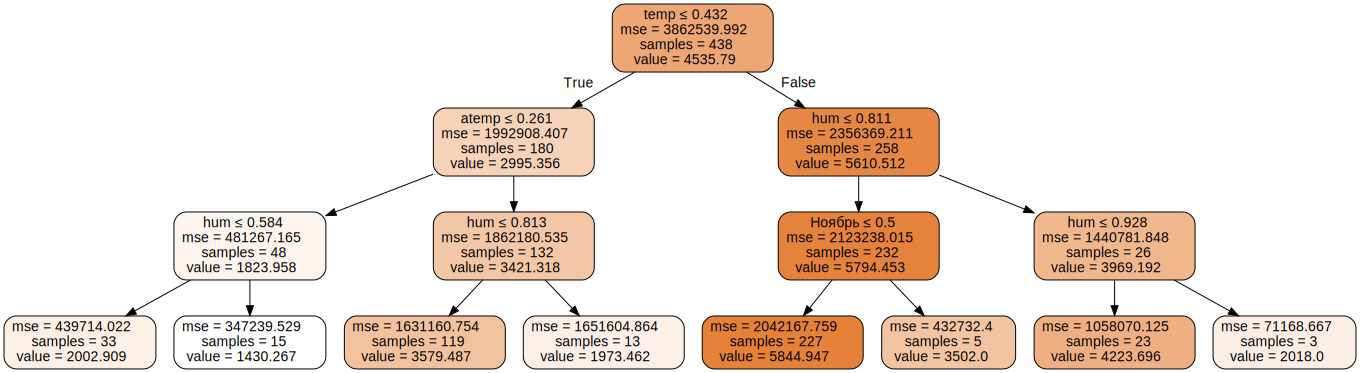

In [13]:
graph = get_graphviz_graph(estimator_for_visualisation)
graph

Подберите оптимальное значение максимальной глубины дерева. Для этого обучите решающие деревья с выставленным значением соответствующего гиперпараметра и посчитайте точность предсказаний каждого из них на валидационной выборке. Постройте соответствующий график.

In [14]:
metric_for_depth = []
for max_level in [1, 2, 3, 5, 10, 20, 40]:
    estimator = DecisionTreeRegressor(max_depth=max_level)
    estimator.fit(X_train, y_train)
    metric_for_depth.append(mean_squared_error(estimator.predict(X_valid), y_valid))

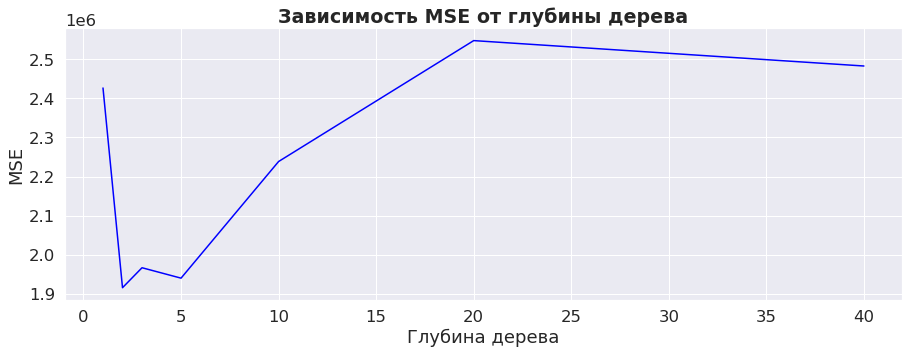

In [15]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot([1, 2, 3, 5, 10, 20, 40], metric_for_depth, color="blue")
    ax.set_xlabel('Глубина дерева')
    ax.set_ylabel("MSE")
    ax.set_title("Зависимость MSE от глубины дерева", fontsize = 19, fontweight = "bold")
    plt.show()

Аналогичным образом подберите минимальное число объектов в листе, зафиксировав при этом подобранное значение максимальной глубины.

In [16]:
metric_for_leaf = []
for min_leaf in [1, 2, 3, 5, 7, 10, 15, 20, 40]:
    estimator = DecisionTreeRegressor(min_samples_leaf = min_leaf, max_depth=5)
    estimator.fit(X_train, y_train)
    metric_for_leaf.append(mean_squared_error(estimator.predict(X_valid), y_valid))

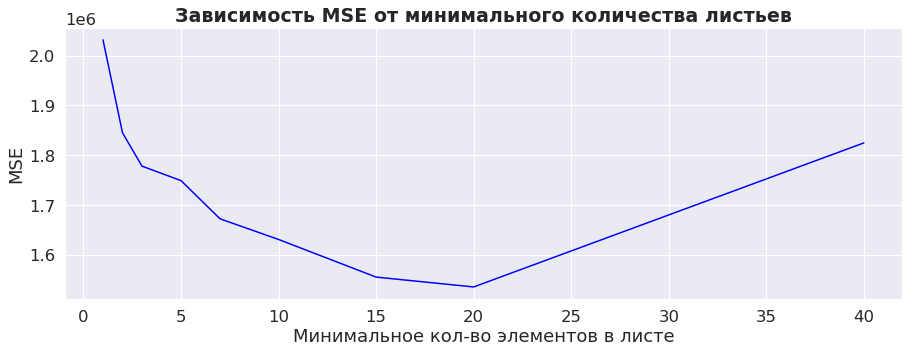

In [17]:
with sns.axes_style('darkgrid'):
    fig2, ax2 = plt.subplots(figsize=(15, 5))
    ax2.plot([1, 2, 3, 5, 7, 10, 15, 20, 40], metric_for_leaf, color="blue")
    ax2.set_xlabel('Минимальное кол-во элементов в листе')
    ax2.set_ylabel("MSE")
    ax2.set_title("Зависимость MSE от минимального количества листьев", fontsize = 19, fontweight = "bold")
    plt.show()

Визуализируйте дерево при оптимальных гиперпараметрах и посчитайте его точность на тестовой части выборки.

In [18]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()

In [19]:
model = DecisionTreeRegressor(max_depth = 5, min_samples_leaf = 20)
model.fit(X_train, y_train)
test_predict = model.predict(X_test)

MSE

In [20]:
print(metrics.mean_squared_error(test[target_feature], test_predict) ** 0.5)

1297.4797169710735


MAE

In [21]:
print(metrics.mean_absolute_error(test[target_feature], test_predict))

1077.2797164626575


MAPE

In [22]:
print(mean_absolute_percentage_error(test[target_feature], test_predict))

34.7401846961512


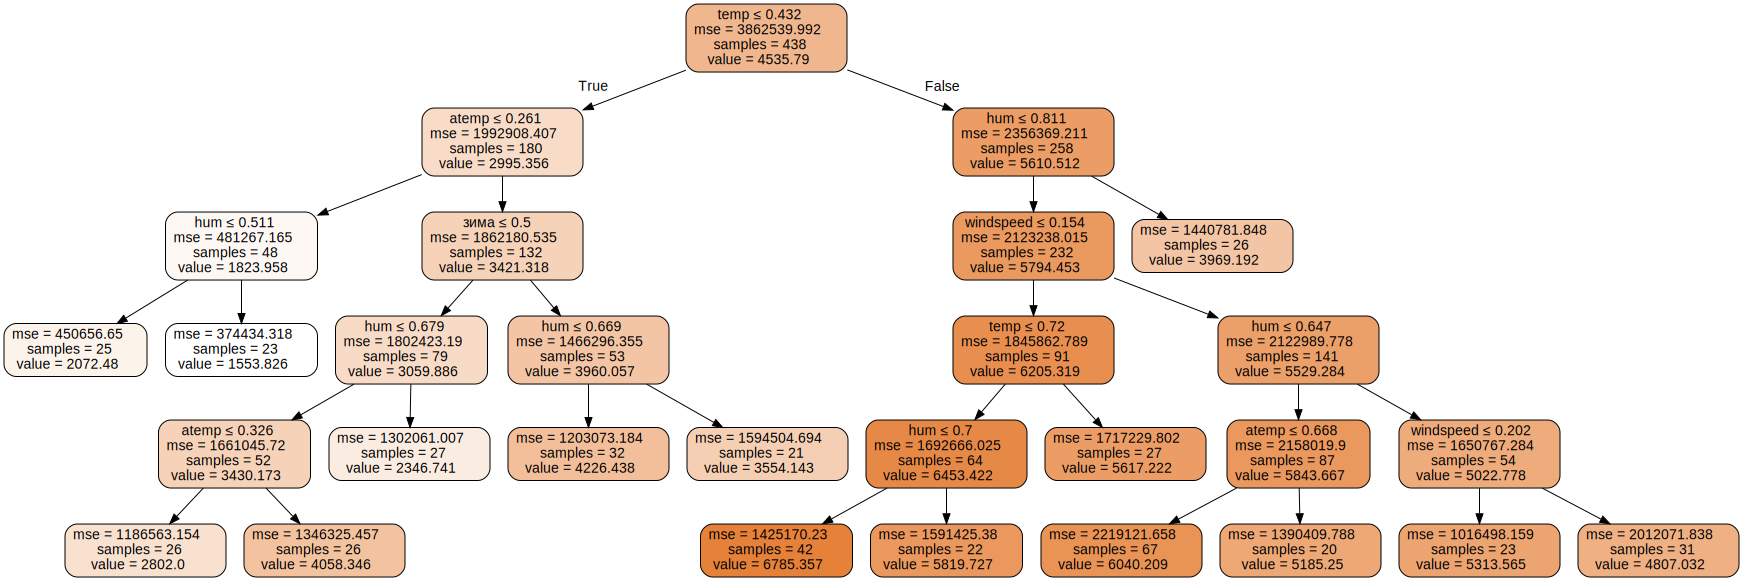

In [23]:
graph_opt = get_graphviz_graph(model)
graph_opt

Решающее дерево позволяет оценить *важность признаков* &mdash; некоторая величина, зависящая от того
* насколько часто тот или иной признак использовался при разбиении листа, 
* и насколько сильно при этом изменился критерий информативности.

У обученной модели значения важности признаков лежат в поле `feature_importances_`. Визуализируйте их с помощью `seaborn.barplot`.

In [24]:
x_cor = [model.feature_importances_[i] for i in range(len(model.feature_importances_)) if model.feature_importances_[i] != 0]
y_cor = [[*real_features, *new_categorial_features][i] for i in range(len(model.feature_importances_)) if model.feature_importances_[i] != 0]

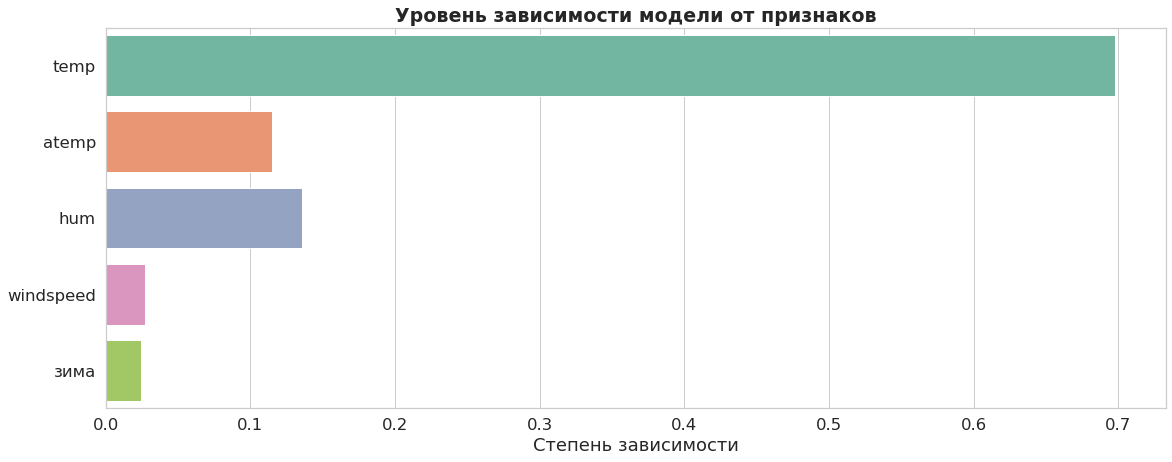

In [25]:
plt.figure(figsize=(19,7))
graphic = sns.barplot(y=y_cor, x=x_cor)
graphic.set_xlabel("Степень зависимости")
graphic.set_title('Уровень зависимости модели от признаков', fontsize = 19, fontweight = "bold")
plt.show()

В данной гистограмме изображены категории, которые имеют хотя бы какую-то степень зависимости.

In [26]:
model.feature_importances_

array([0.69793483, 0.11492857, 0.1357496 , 0.02709296, 0.        ,
       0.        , 0.        , 0.02429404, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

Сделайте выводы.

**Вывод:**

**1)** В первой части на валидационной выборке были протестированы и получены такие параметры, как максимальная глубина дерева и минимальное количество наблюдений в листе.

**2)** Если сравнивать результаты с полученными результатами в прошлом задании, где все было подсчитано градиентным спуском, то можно увидеть, что результаты метрик, примерно, одни и те же. Однако в данном случае мы получили разные оценки влияния признаков. Так, например, из категориальных признаков значимым является только зима.Это можно объяснить тем, что зимой резко снижается количество арендованных велосипедов. Наиболее значимым признаком оказалась температура.

---
### Задача 3.

Для данных из предыдущей части обучите случайный лес на 500 деревьев.

In [27]:
model_forest = RandomForestRegressor(n_estimators=500)
model_forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500)

In [28]:
pred_forest = model_forest.predict(X_test)

MSE

In [29]:
print(metrics.mean_squared_error(test[target_feature], pred_forest) ** 0.5)

1243.7863560082135


MAE

In [30]:
print(metrics.mean_absolute_error(test[target_feature], pred_forest))

1014.8080680272109


MAPE

In [31]:
print(mean_absolute_percentage_error(test[target_feature], pred_forest))

35.677621876042224


Постройте график зависимости точности модели в зависимости от количества деревьев для обучающей и валидационной выборок.

*Замечание.* Не нужно заново обучать лес каждый раз. Используйте у обученной модели поле `estimators_`, это список из объектов класса `DecisionTreeRegressor`.

In [32]:
valid_metric_forest = []
train_metric_forest = []
for count_forest in range(1, 501):
    valid_metric_forest.append(metrics.mean_squared_error(valid[target_feature], np.mean(list(map(lambda x: x.predict(X_valid), model_forest.estimators_[0:count_forest])), axis = 0)) ** 0.5)
    train_metric_forest.append(metrics.mean_squared_error(train[target_feature], np.mean(list(map(lambda x: x.predict(X_train), model_forest.estimators_[0:count_forest])), axis = 0)) ** 0.5)

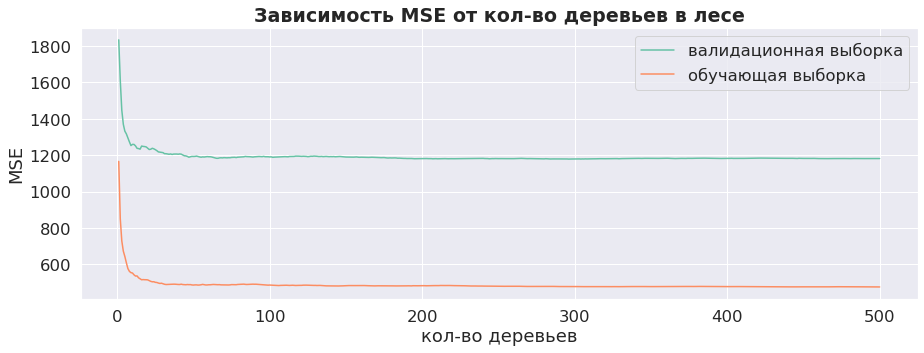

In [33]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(range(1, 501), valid_metric_forest, label = 'валидационная выборка')
    ax.plot(range(1, 501), train_metric_forest, label = 'обучающая выборка')
    ax.set_xlabel('кол-во деревьев')
    ax.set_ylabel("MSE")
    ax.legend()
    ax.set_title("Зависимость MSE от кол-во деревьев в лесе", fontsize = 19, fontweight = "bold")
    plt.show()

Для леса с максимальным количеством деревьев визуализируйте
важность признаков, используя поле `feature_importances_`. 

In [34]:
x_cor_for = [model_forest.feature_importances_[i] for i in range(len(model_forest.feature_importances_)) if model_forest.feature_importances_[i] != 0]
y_cor_for = [[*real_features, *new_categorial_features][i] for i in range(len(model_forest.feature_importances_)) if model_forest.feature_importances_[i] != 0]

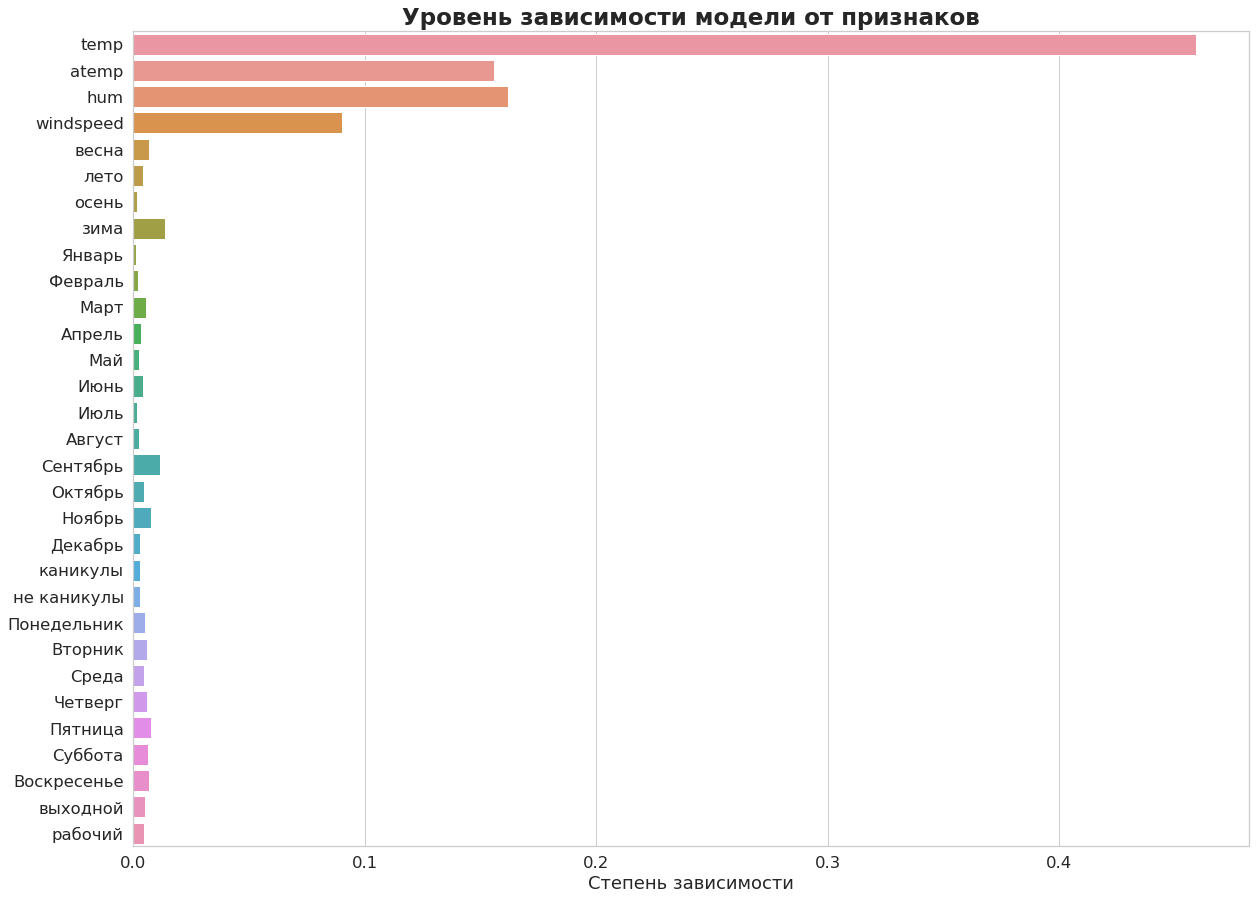

In [35]:
plt.figure(figsize=(20,15))
graphic = sns.barplot(y=y_cor_for, x=x_cor_for)
graphic.set_xlabel("Степень зависимости")
graphic.set_title('Уровень зависимости модели от признаков', fontsize = 23, fontweight = "bold")
plt.show()

Сделайте выводы.

**Вывод:**

**1**) Легко заметить, что качество модели увеличивается с ростом количества дереьвев в случайном лесу. И к 500 уже фактически не меняется. Также стоит отметить, что качество улучшилось по сравнению с тем, которое мы получали во время обучения одного дерева.

**2**) Что касается уровня зависимости модели от признаков, заметим, что ключевые признаки не изменились, однако можно увидеть влияние и других признаков, например, весны.